<a href="https://colab.research.google.com/github/shlomi-idc/Final_Project/blob/main/MRI_training_3D_cross_validation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports and constants

In [ ]:
!pip install -q segmentation-models-pytorch

In [ ]:
!pip install torchmetrics

In [ ]:
import os
from tqdm import tqdm
from google.colab import drive
import pandas as pd
from glob import glob
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import albumentations as A
import torch
import json
from collections import defaultdict
import segmentation_models_pytorch as smp
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import MeanMetric
from torchmetrics.classification import BinaryAccuracy
import time
from tqdm import tqdm
import cv2
import shutil
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage.morphology import binary_dilation
from datetime import datetime
import numpy as np
import scipy
import imageio
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
import torch.nn.utils as nn_utils
import zipfile
from datetime import datetime
import math
import warnings
warnings.filterwarnings("ignore")


In [ ]:
KAGGLE_DATA_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/kaggle_3m.zip'
GENERATE_DATESET = False
DATA_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_19_middle'
CSV_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/Copy of data.csv'
RESULTS_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/results'
VISUALIZE_PLOTS = False

DATA_PATHS = {}
DATA_PATHS['chunk_1'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_1'
DATA_PATHS['chunk_3'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_3_middle'
DATA_PATHS['chunk_5'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_5_middle'
DATA_PATHS['chunk_7'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_7_middle'
DATA_PATHS['chunk_9'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_9_middle'
DATA_PATHS['chunk_11'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_11_middle'
DATA_PATHS['chunk_13'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_13_middle'
DATA_PATHS['chunk_15'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_15_middle'
DATA_PATHS['chunk_17'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_17_middle'
DATA_PATHS['chunk_19'] = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_19_middle'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile(KAGGLE_DATA_PATH, 'r')
zip_ref.extractall("/content")
zip_ref.close()


In [ ]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

#generate daatset

In [ ]:
data_dir = '/content/kaggle_3m'
os.chdir(data_dir)
print(os.getcwd())
csv_path = CSV_PATH

/content/kaggle_3m


In [ ]:
file_paths = glob(f'{os.getcwd()}/*/*[0-9].tif')

In [ ]:
file_paths

['/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_10.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_23.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_26.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_2.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_31.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_7.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_3.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_24.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_9.tif',
 '/content/kaggle_3m/TCGA_DU_A5TW_19980228/

In [ ]:
df = pd.read_csv(csv_path)
for column in df.columns:
  print(column)
  if column == 'age_at_initial_pathologic':
    df[column] = df[column].astype('Int64')
  else:
    df[column] = df[column].astype('category')


Patient
RNASeqCluster
MethylationCluster
miRNACluster
CNCluster
RPPACluster
OncosignCluster
COCCluster
histological_type
neoplasm_histologic_grade
tumor_tissue_site
laterality
tumor_location
gender
age_at_initial_pathologic
race
ethnicity
death01


In [ ]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df.head(5)

,Patient,image_filename,mask_filename
0,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
1,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
2,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
3,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
4,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...


In [ ]:
df = pd.merge(df, filenames_df, on="Patient")


In [ ]:
arr = df['Patient'].unique()


In [ ]:
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
1,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
2,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
3,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
4,TCGA_DU_A5TW,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...,/content/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_...
...,...,...,...
3924,TCGA_HT_7608,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...
3925,TCGA_HT_7608,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...
3926,TCGA_HT_7608,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...
3927,TCGA_HT_7608,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...,/content/kaggle_3m/TCGA_HT_7608_19940304/TCGA_...


In [ ]:
if GENERATE_DATESET:

  NEW_DATA_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_19_middle'
  CUNK_SIZE = 19

  for patient_name in tqdm(arr):

    patient_planes = filenames_df[filenames_df['Patient']==patient_name].sort_values(by=['image_filename'], ascending=False)
    patient_planes['last_number'] = patient_planes['image_filename'].str.extract(r'(\d+)\.tif$').astype(int)
    df_sorted = patient_planes.sort_values(by='last_number')
    df_sorted = df_sorted.drop(columns='last_number')
    df_sorted.reset_index(inplace=True, drop=True)

    df_sorted['chunk'] = df_sorted.index // CUNK_SIZE
    df_sorted['position_in_chunk'] = df_sorted.index % CUNK_SIZE
    # Calculate the size of each chunk and map it back to the DataFrame
    chunk_sizes = df_sorted.groupby('chunk')['chunk'].transform('size') # Add a column that marks with 0 if the chunk is less than the chunk size and 1 otherwise
    df_sorted['is_full_chunk'] = (chunk_sizes == CUNK_SIZE).astype(int)

    for j in range(len(df_sorted['chunk'].unique())):


        img_path = os.path.join(NEW_DATA_PATH, f'{patient_name}_{j}')
        mask_path = os.path.join(NEW_DATA_PATH, f'{patient_name}_{j}_mask')

        sample_imgs = []
        sample_masks = []


        for i, (_, row) in enumerate(df_sorted[df_sorted['chunk']==j].iterrows()):

          img = cv2.imread(row.image_filename)
          mask = cv2.imread(row.mask_filename, cv2.IMREAD_GRAYSCALE)

          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          sample_imgs.append(img)
          sample_masks.append(mask)

        sample_imgs_arr = np.stack(sample_imgs)
        sample_masks_arr = np.stack(sample_masks)


        if df_sorted[df_sorted['chunk']==j].iloc[0].is_full_chunk==0: #not full chunk

          num_planes_to_add = CUNK_SIZE - sample_imgs_arr.shape[0]


          sample_imgs_arr = np.concatenate([sample_imgs_arr, prev_sample_imgs_arr [-num_planes_to_add:]])
          sample_masks_arr = np.concatenate([sample_masks_arr, prev_sample_masks_arr [-num_planes_to_add:]])

        prev_sample_imgs_arr = sample_imgs_arr
        prev_sample_masks_arr = sample_masks_arr

        sample_masks_arr = sample_masks_arr[CUNK_SIZE//2]

        assert sample_imgs_arr.shape[0] == CUNK_SIZE

        np.save(img_path, sample_imgs_arr)
        np.save(mask_path, sample_masks_arr)




#load dataset

In [ ]:
data_dir = DATA_PATH
os.chdir(data_dir)
print(os.getcwd())
csv_path = CSV_PATH

/content/drive/MyDrive/MRI_segmetnation_project/3d_data_chunk_19_middle


In [ ]:
file_paths = glob(f'{os.getcwd()}/*[0-9].npy')

In [ ]:
# file_paths

In [ ]:
df = pd.read_csv(csv_path)
for column in df.columns:
  print(column)
  if column == 'age_at_initial_pathologic':
    df[column] = df[column].astype('Int64')
  else:
    df[column] = df[column].astype('category')


Patient
RNASeqCluster
MethylationCluster
miRNACluster
CNCluster
RPPACluster
OncosignCluster
COCCluster
histological_type
neoplasm_histologic_grade
tumor_tissue_site
laterality
tumor_location
gender
age_at_initial_pathologic
race
ethnicity
death01


In [ ]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df.head(5)

,Patient,image_filename,mask_filename
0,TCGA_CS_4941,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
1,TCGA_CS_4941,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
2,TCGA_CS_4942,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
3,TCGA_CS_4942,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
4,TCGA_CS_4943,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...


In [ ]:
def load_data(data_dir = DATA_PATH, csv_path = CSV_PATH):
  os.chdir(data_dir)
  file_paths = glob(f'{os.getcwd()}/*[0-9].npy')
  if len(file_paths) == 0:
    file_paths = glob(f'{os.getcwd()}/*/*[0-9].tif')
  df = pd.read_csv(csv_path)
  for column in df.columns:
    if column == 'age_at_initial_pathologic':
      df[column] = df[column].astype('Int64')
    else:
      df[column] = df[column].astype('category')
  filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
  filenames_df.head(5)
  df = pd.merge(df, filenames_df, on="Patient")
  arr = df['Patient'].unique()

  return df, arr

#create data loader

In [ ]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25, is_channel_included=[True, True, True], single_slice = False):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        self.is_channel_included = [i for i, is_included  in enumerate(is_channel_included) if is_included==True]
        self.single_slice = single_slice

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]

        img = np.load(row['image_filename'])

        # which cahnnel to include (pre-contrast, FLAIR, post-contrast)
        img = img[:, :, :, self.is_channel_included]

        mask = np.load(row['mask_filename'])

        if raw:
            return img, mask

        if self.single_slice:
          img = np.squeeze(img, axis=0)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        img = img / 255
        img = torch.Tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)

        #reshape to C, D, H, W
        if self.single_slice:
          img = img.permute(2, 0, 1)
        else:
          img = img.permute(3, 0, 1, 2)

        return img, mask

In [ ]:


class MriDatasetDetailed(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25, is_channel_included=[True, True, True], single_slice = False):
        super(MriDatasetDetailed, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        self.is_channel_included = [i for i, is_included  in enumerate(is_channel_included) if is_included==True]
        self.single_slice = single_slice


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]

        img = np.load(row['image_filename'])

        # which cahnnel to include (pre-contrast, FLAIR, post-contrast)
        img = img[:, :, :, self.is_channel_included]

        mask = np.load(row['mask_filename'])

        if math.isnan(row['neoplasm_histologic_grade']):
          hist_grade = 2 #if Nan then assume hist=2
        else:
          hist_grade = int(row['neoplasm_histologic_grade'])
        if isinstance(row['age_at_initial_pathologic'], type(pd.NA)):
          age = 47
        else:
          age = int(row['age_at_initial_pathologic'])

        df_planes_number, _ = load_data('/content/kaggle_3m')

        df_planes_number = df_planes_number.groupby('Patient')['image_filename'].count().reset_index()

        df_planes_number = df_planes_number.rename(columns = {"image_filename": "number_of_planes"})


        patient = "_".join(row['image_filename'].split('/')[-1].split('_')[:-1])

        number_of_planes = df_planes_number[df_planes_number["Patient"]==patient]["number_of_planes"].tolist()[0]

        if raw:
            return img, mask

        if self.single_slice:
          img = np.squeeze(img, axis=0)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        img = img / 255
        img = torch.Tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)

        #reshape to C, D, H, W
        if self.single_slice:
          img = img.permute(2, 0, 1)
        else:
          img = img.permute(3, 0, 1, 2)


        return img, mask, hist_grade, age, number_of_planes

In [ ]:
df = pd.merge(df, filenames_df, on="Patient")


In [ ]:
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_CS_4941,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
1,TCGA_CS_4941,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
2,TCGA_CS_4942,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
3,TCGA_CS_4942,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
4,TCGA_CS_4943,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
...,...,...,...
257,TCGA_HT_A61B,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
258,TCGA_HT_A61B,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
259,TCGA_HT_A61B,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...
260,TCGA_HT_A61B,/content/drive/MyDrive/MRI_segmetnation_projec...,/content/drive/MyDrive/MRI_segmetnation_projec...


In [ ]:
arr = df['Patient'].unique()
train_arr, test_arr = train_test_split(arr, test_size=0.3, random_state=42)
test_arr, valid_arr = train_test_split(test_arr, test_size=0.5, random_state=43)

In [ ]:
train_df = df[df['Patient'].isin(train_arr)]
valid_df = df[df['Patient'].isin(valid_arr)]
test_df = df[df['Patient'].isin(test_arr)]

In [ ]:

class EarlyStopping():
    """
    Stops training when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        """
        :param patience: number of epochs of non-decreasing loss before stopping
        :param min_delta: minimum difference between best and new loss that is considered
            an improvement
        :paran weights_path: Path to the file that should store the model's weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_dice = 0

        self.weights_path = weights_path

    def __call__(self, val_loss: float, dice_score: float, model: torch.nn.Module):
        if dice_score > self.best_dice :
            self.best_dice = dice_score
            torch.save(model.state_dict(), self.weights_path)
            print("saved_model")
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        """
        Loads weights of the best model.
        :param model: model to which the weigths should be loaded
        """
        return model.load_state_dict(torch.load(self.weights_path,  weights_only=True))

In [ ]:
def iou_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7, single_mask=False, threshold = 0.5):
    """Calculates Intersection over Union for a tensor of predictions"""
    predictions = torch.where(predictions > threshold, 1, 0)
    labels = labels.byte()

    if  single_mask:
      intersection = (predictions & labels).float().sum((1, 2))
      union = (predictions | labels).float().sum((1, 2))
    else:
      intersection = (predictions & labels).float().sum((1, 2, 3))
      union = (predictions | labels).float().sum((1, 2, 3))

    iou = (intersection + e) / (union + e)

    return iou

def dice_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7,  single_mask=True, threshold = 0.5):
    """Calculates Dice coefficient for a tensor of predictions"""
    predictions = torch.where(predictions > threshold, 1, 0)
    labels = labels.byte()

    if  single_mask:
      intersection = (predictions & labels).float().sum((1, 2))
      denominator = predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e
    else:
      intersection = (predictions & labels).float().sum((1, 2, 3))
      denominator = predictions.float().sum((1, 2, 3)) + labels.float().sum((1, 2, 3)) + e


    numerator = (2 * intersection) + e

    return (numerator/denominator)

In [ ]:
def BCE_dice(output, target, alpha=0.01):
    bce = torch.nn.functional.binary_cross_entropy(output, target)
    soft_dice = 1 - dice_pytorch(output, target).mean()

    return bce + alpha * soft_dice


In [ ]:
def focal_dice(output, target, alpha=0.01):
    focal_loss = smp.losses.FocalLoss(
    mode="binary",          # Multi-class segmentation
    alpha=0.5,                 # class weighting to deal with class imbalance
    gamma=2.0                   # Focusing parameter for hard-to-classify examples
    )

    dice_loss = smp.losses.DiceLoss(
    mode="binary",          # For binary segmentation
    classes=None,               # Compute the loss for all classes
    log_loss=False,             # Do not use log version of Dice loss
    from_logits=False,          # Model outputs are raw logits
    smooth=1e-5,                # A small smoothing factor for stability
    ignore_index=None,          # Don't ignore any classes
    eps=1e-7                    # Epsilon for numerical stability
    )

    return dice_loss(output, target) + alpha * focal_loss(output, target)


# 3d unet architecture

In [ ]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Convlution set one
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            # Convlution set two
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)

          )

    def forward(self,x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2)),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        # max pooling 3d + doubleConv
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d_new(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels, chunk_size):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.chunk_size = chunk_size

        # extracting the features by incrementally multiplying the no.of channels
        self.conv = DoubleConv(in_channels, n_channels) #24
        self.enc1 = Down(n_channels, 2 * n_channels) #48
        self.enc2 = Down(2 * n_channels, 4 * n_channels) #96
        self.enc3 = Down(4 * n_channels, 4 * n_channels) #96

        self.dec2 = Up(8 * n_channels, 2 * n_channels) #48
        self.dec3 = Up(4 * n_channels, n_channels) #24
        self.dec4 = Up(2 * n_channels, n_channels) #24
        self.out = Out(n_channels, n_classes) #1
        self.out_2 = Out(n_classes * self.chunk_size, n_classes) #1


    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)

        mask = self.dec2(x4, x3)# 96 channels + 96 channels
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)

        mask = self.out(mask)

        mask = torch.reshape(mask, (mask.shape[0],-1, 1, mask.shape[3], mask.shape[4]))

        mask = self.out_2(mask)

        mask = mask.squeeze(2)

        mask = torch.sigmoid(mask)

        """
        After a series of either Upsampling / 3d Transpose
        a segmented image of the input image is generated
        & returned
        """
        return mask

#unet 2d

In [ ]:
class DoubleConv_2d(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Convlution set one
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            # Convlution set two
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)

          )

    def forward(self,x):
        return self.double_conv(x)

class Down_2d(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            DoubleConv_2d(in_channels, out_channels)
        )
    def forward(self, x):
        # max pooling 3d + doubleConv
        return self.encoder(x)


class Up_2d(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv_2d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out_2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet2d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels, chunk_size):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.chunk_size = chunk_size

        # extracting the features by incrementally multiplying the no.of channels
        self.conv = DoubleConv_2d(in_channels, n_channels) #24
        self.enc1 = Down_2d(n_channels, 2 * n_channels) #48
        self.enc2 = Down_2d(2 * n_channels, 4 * n_channels) #96
        self.enc3 = Down_2d(4 * n_channels, 4 * n_channels) #96
        # self.enc4 = Down_2d(8 * n_channels, 8 * n_channels) #192

        # self.dec1 = Up_2d(16 * n_channels, 4 * n_channels) #96
        self.dec2 = Up_2d(8 * n_channels, 2 * n_channels) #48
        self.dec3 = Up_2d(4 * n_channels, n_channels) #24
        self.dec4 = Up_2d(2 * n_channels, n_channels) #24
        self.out = Out_2d(n_channels, n_classes) #1
        self.out_2 = Out_2d(n_classes * self.chunk_size, n_classes) #1


    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)

        mask = self.dec2(x4, x3)# 96 channels + 96 channels
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)

        mask = self.out(mask)

        mask = self.out_2(mask)

        mask = torch.sigmoid(mask)

        """
        After a series of either Upsampling / 3d Transpose
        a segmented image of the input image is generated
        & returned
        """
        return mask

#Training

In [ ]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler, alpha=1, weights_path='', single_mask = False, test_loader=None, chunk_slice=True, chunk_size=1, universal_test_loader=None):

    history = defaultdict(list)

    early_stopping = EarlyStopping(patience=7, weights_path=weights_path)

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # running_loss = 0
        loss_record = MeanMetric()

        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask, alpha)
            loss_record.update(loss.detach().cpu().item(), weight=img.shape[0])
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()


        model.eval()

        with torch.no_grad():

            iou_record = MeanMetric()
            f1_record = MeanMetric()
            precision_record = MeanMetric()
            recall_record = MeanMetric()
            specificity_record = MeanMetric()
            loss_record_validation = MeanMetric()
            loss_record_test = MeanMetric()


            acc_record = BinaryAccuracy()


            running_IoU = 0
            running_dice = 0
            running_valid_loss = 0
            running_IoU_ours = 0


            for i, data in enumerate(test_loader):

                img, mask = data

                if chunk_slice:
                  slices_to_remove = img.shape[2] - chunk_size
                if slices_to_remove //2 > 0:
                  img = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
                if chunk_size==1:
                  img = img.squeeze(2)

                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)


                # Calculate stats and IoU
                mask = mask.int()

                tp, fp, fn, tn = smp.metrics.get_stats(predictions.unsqueeze(0), mask.unsqueeze(0), mode='binary', threshold=0.5)
                # Macro IoU and class-wise IoU

                iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
                # print(tp, fp, fn, tn)
                # print(iou_macro)
                # print(iou_pytorch(predictions, mask, single_mask=single_mask).item())
                f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
                precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
                recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
                specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="macro")


                acc_record.update(predictions.cpu(), mask.cpu())
                iou_record.update(iou_macro.cpu(), weight=img.shape[0])
                f1_record.update(f1_score.cpu(), weight=img.shape[0])
                recall_record.update(recall.cpu(), weight=img.shape[0])
                specificity_record.update(specificity.cpu(), weight=img.shape[0])
                precision_record.update(precision.cpu(), weight=img.shape[0])

                running_dice += dice_pytorch(predictions, mask, single_mask=single_mask).item()
                running_IoU_ours += iou_pytorch(predictions, mask, single_mask=single_mask).item()
                loss = loss_fn(predictions, mask, alpha)

                loss_record_test.update(loss.detach().cpu().item(), weight=img.shape[0])


            universal_iou_record = MeanMetric()
            universal_f1_record = MeanMetric()
            universal_precision_record = MeanMetric()
            universal_recall_record = MeanMetric()
            universal_specificity_record = MeanMetric()
            universal_loss_record_validation = MeanMetric()
            universal_loss_record_test = MeanMetric()


            universal_acc_record = BinaryAccuracy()


            universal_running_IoU = 0
            universal_running_dice = 0
            universal_running_valid_loss = 0
            universal_running_IoU_ours = 0


            for i, data in enumerate(universal_test_loader):

                img, mask = data

                if chunk_slice:
                  slices_to_remove = img.shape[2] - chunk_size
                if slices_to_remove //2 > 0:
                  img = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
                if chunk_size==1:
                  img = img.squeeze(2)

                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)


                # Calculate stats and IoU
                mask = mask.int()

                tp, fp, fn, tn = smp.metrics.get_stats(predictions.unsqueeze(0), mask.unsqueeze(0), mode='binary', threshold=0.5)
                # Macro IoU and class-wise IoU

                iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
                f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
                precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
                recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
                specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="macro")


                universal_acc_record.update(predictions.cpu(), mask.cpu())
                universal_iou_record.update(iou_macro.cpu(), weight=img.shape[0])
                universal_f1_record.update(f1_score.cpu(), weight=img.shape[0])
                universal_recall_record.update(recall.cpu(), weight=img.shape[0])
                universal_specificity_record.update(specificity.cpu(), weight=img.shape[0])
                universal_precision_record.update(precision.cpu(), weight=img.shape[0])

                universal_running_dice += dice_pytorch(predictions, mask, single_mask=single_mask).item()
                universal_running_IoU_ours += iou_pytorch(predictions, mask, single_mask=single_mask).item()
                universal_loss = loss_fn(predictions, mask, alpha)

                universal_loss_record_test.update(universal_loss.detach().cpu().item(), weight=img.shape[0])

            for i, data in enumerate(valid_loader):

                img, mask = data

                if chunk_slice:
                  slices_to_remove = img.shape[2] - chunk_size
                if slices_to_remove //2 > 0:
                  img = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
                if chunk_size==1:
                  img = img.squeeze(2)

                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)

                # Calculate stats and IoU
                mask = mask.int()

                loss = loss_fn(predictions, mask, alpha)

                loss_record_validation.update(loss.detach().cpu().item(), weight=img.shape[0])


        val_loss = loss_record_validation.compute()
        test_loss = loss_record_test.compute()
        val_dice = running_dice / len(valid_loader.dataset)
        val_IoU_ours = running_IoU_ours / len(valid_loader.dataset)


        val_IoU = iou_record.compute()
        val_acc = acc_record.compute()
        val_f1 = f1_record.compute()
        val_recall = recall_record.compute()
        val_specificity = specificity_record.compute()
        val_precision = precision_record.compute()

        train_loss = loss_record.compute()


        universal_test_loss = universal_loss_record_test.compute()
        universal_test_dice = universal_running_dice / len(universal_test_loader.dataset)
        universal_test_IoU_ours = universal_running_IoU_ours / len(universal_test_loader.dataset)


        universal_test_IoU = universal_iou_record.compute()
        universal_test_acc = universal_acc_record.compute()
        universal_test_f1 = universal_f1_record.compute()
        universal_test_recall = universal_recall_record.compute()
        universal_test_specificity = universal_specificity_record.compute()
        universal_test_precision = universal_precision_record.compute()


        history['train_loss'].append(train_loss.item())
        history['val_loss'].append(val_loss.item())
        history['test_loss'].append(test_loss.item())
        history['val_IoU'].append(val_IoU.item())
        history['val_IoU_ours'].append(val_IoU_ours)
        history['val_dice'].append(val_dice)
        history['val_acc'].append(val_acc.item())
        history['val_precision'].append(val_precision.item())
        history['val_recall'].append(val_recall.item())
        history['val_specificity'].append(val_specificity.item())
        history['val_f1'].append(val_f1.item())

        history['universal_test_loss'].append(universal_test_loss.item())
        history['universal_test_IoU'].append(universal_test_IoU.item())
        history['universal_test_IoU_ours'].append(universal_test_IoU_ours)
        history['universal_test_dice'].append(universal_test_dice)
        history['universal_test_acc'].append(universal_test_acc.item())
        history['universal_test_precision'].append(universal_test_precision.item())
        history['universal_test_recall'].append(universal_test_recall.item())
        history['universal_test_specificity'].append(universal_test_specificity.item())
        history['universal_test_f1'].append(universal_test_f1.item())




        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss} | Validation Mean IoU: {val_IoU} '
         f'| Validation Dice coefficient: {val_dice} | Validation Accuracy: {val_acc}')

        if early_stopping(val_loss, val_dice, model):
            early_stopping.load_weights(model)
            break
    model.eval()
    return history, model

#Cross validation

In [ ]:
model_information = {}
model_information['ALPHA'] = 1
model_information['LR'] = 0.001
model_information['IN_CLASSES'] = 3
model_information['N_CHANNELS'] = 24
model_information['MODEL_NAME'] = 'baseline_3d_unet_chunk_1_middle'
model_information['EPOCHS'] = 3
model_information['MODELS_PATH'] = '/content/drive/MyDrive/MRI_segmetnation_project/models'
model_information['CHUNK_SIZE'] = 1
model_information['SINGLE_MASK'] = True
model_information['IS_CHANNEL_INCLUDED'] = [True, True, True]
model_information['BATCH_SIZE'] = 32


In [ ]:
def cross_validtion_training(model_information, df, arr, data_paths, n_splits = 5):

    current_time= datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    results_dictionary_path = os.path.join(RESULTS_PATH, f"results_{model_information['MODEL_NAME']}_{current_time}.csv")

    df, arr = load_data(data_dir = DATA_PATHS[f"chunk_{model_information['CHUNK_SIZE'] }"])

    df_chunk_19, arr_chunk_19 = load_data(data_dir = DATA_PATHS['chunk_19'])

    train_val_arr, test_arr = train_test_split(arr, test_size=0.15, random_state=42)

    train_val_arr_chunk_19, test_arr_chunk_19 = train_test_split(arr_chunk_19, test_size=0.15, random_state=42)


    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = defaultdict(list)

    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_val_arr)):

        print(f"training started for fold = {fold}")

        train_arr = train_val_arr[train_ids]
        valid_arr = train_val_arr_chunk_19[valid_ids]

        train_df = df[df['Patient'].isin(train_arr)]
        valid_df = df_chunk_19[df_chunk_19['Patient'].isin(valid_arr)]
        universal_test_df = df_chunk_19[df_chunk_19['Patient'].isin(test_arr_chunk_19)]

        transform = None

        single_slice = True if model_information['CHUNK_SIZE'] == 1 else False

        train_dataset = MriDataset(train_df, transform, is_channel_included=model_information['IS_CHANNEL_INCLUDED'], single_slice = single_slice)
        valid_dataset = MriDataset(valid_df, is_channel_included=model_information['IS_CHANNEL_INCLUDED'])
        universal_test_dataset = MriDataset(universal_test_df, is_channel_included=model_information['IS_CHANNEL_INCLUDED'])


        train_loader = DataLoader(train_dataset, batch_size=model_information['BATCH_SIZE'], shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=model_information['BATCH_SIZE'], shuffle=True)
        test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
        universal_test_loader = DataLoader(universal_test_dataset, batch_size=1, shuffle=True)

        current_time= datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
        WEIGHTS_PATH = os.path.join(model_information['MODELS_PATH'], f"{model_information['MODEL_NAME']}_fold_{fold}_{current_time}.pt")

        if model_information['CHUNK_SIZE'] > 1:
          model = UNet3d_new(in_channels=model_information['IN_CLASSES'], n_classes=1, n_channels=model_information['N_CHANNELS'], chunk_size=model_information['CHUNK_SIZE'])

        else:
          model = UNet2d(in_channels=model_information['IN_CLASSES'], n_classes=1, n_channels=model_information['N_CHANNELS'], chunk_size=model_information['CHUNK_SIZE'])

        model.to(device)

        loss_fn = focal_dice
        optimizer = Adam(model.parameters(), lr=model_information['LR'])
        epochs = model_information['EPOCHS']
        lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2,factor=0.2)

        history, model = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler, test_loader=test_loader, alpha=model_information['ALPHA'], weights_path=WEIGHTS_PATH, single_mask=model_information['SINGLE_MASK'] , chunk_size = model_information['CHUNK_SIZE'], universal_test_loader=universal_test_loader)

        json_path = os.path.join(RESULTS_PATH, f"history_{model_information['MODEL_NAME']}_fold_{fold}_{current_time}.json")

        with open(json_path, 'w') as file:
          json.dump(history, file, indent = 4)

        # best_index= history['val_loss'].index(min(history['val_loss']))
        best_index= history['val_dice'].index(max(history['val_dice']))
        results['val_loss'].append(history['test_loss'][best_index]) # test_loss is val loss with batch size = 1
        results['val_IoU'].append(history['val_IoU'][best_index])
        results['val_IoU_ours'].append(history['val_IoU_ours'][best_index])
        results['val_dice'].append(history['val_dice'][best_index])
        results['val_acc'].append(history['val_acc'][best_index])
        results['val_precision'].append(history['val_precision'][best_index])
        results['val_recall'].append(history['val_recall'][best_index])
        results['val_f1'].append(history['val_f1'][best_index])
        results['val_specificity'].append(history['val_specificity'][best_index])


        results['universal_test_loss'].append(history['universal_test_loss'][best_index]) # test_loss is val loss with batch size = 1
        results['universal_test_IoU'].append(history['universal_test_IoU'][best_index])
        results['universal_test_IoU_ours'].append(history['universal_test_IoU_ours'][best_index])
        results['universal_test_dice'].append(history['universal_test_dice'][best_index])
        results['universal_test_acc'].append(history['universal_test_acc'][best_index])
        results['universal_test_precision'].append(history['universal_test_precision'][best_index])
        results['universal_test_recall'].append(history['universal_test_recall'][best_index])
        results['universal_test_f1'].append(history['universal_test_f1'][best_index])
        results['universal_test_specificity'].append(history['universal_test_specificity'][best_index])

    results = pd.DataFrame(results)

    results['val_loss_mean'] = np.mean(results['val_loss'])
    results['val_IoU_mean'] = np.mean(results['val_IoU'])
    results['val_IoU_ours_mean'] = np.mean(results['val_IoU_ours'])
    results['val_dice_mean'] = np.mean(results['val_dice'])
    results['val_acc_mean'] = np.mean(results['val_acc'])
    results['val_recall_mean'] = np.mean(results['val_recall'])
    results['val_precision_mean'] = np.mean(results['val_precision'])
    results['val_f1_mean'] = np.mean(results['val_f1'])
    results['val_specificity_mean'] = np.mean(results['val_specificity'])

    results['val_loss_std'] = np.std(results['val_loss'])
    results['val_IoU_std'] = np.std(results['val_IoU'])
    results['val_IoU_ours_std'] = np.std(results['val_IoU_ours'])
    results['val_dice_std'] = np.std(results['val_dice'])
    results['val_acc_std'] = np.std(results['val_acc'])


    results['universal_test_loss_mean'] = np.mean(results['universal_test_loss'])
    results['universal_test_IoU_mean'] = np.mean(results['universal_test_IoU'])
    results['universal_test_IoU_ours_mean'] = np.mean(results['universal_test_IoU_ours'])
    results['universal_test_dice_mean'] = np.mean(results['universal_test_dice'])
    results['universal_test_acc_mean'] = np.mean(results['universal_test_acc'])
    results['universal_test_recall_mean'] = np.mean(results['universal_test_recall'])
    results['universal_test_precision_mean'] = np.mean(results['universal_test_precision'])
    results['universal_test_f1_mean'] = np.mean(results['universal_test_f1'])
    results['universal_test_specificity_mean'] = np.mean(results['universal_test_specificity'])

    results['universal_test_loss_std'] = np.std(results['universal_test_loss'])
    results['universal_test_IoU_std'] = np.std(results['universal_test_IoU'])
    results['universal_test_IoU_ours_std'] = np.std(results['universal_test_IoU_ours'])
    results['universal_test_dice_std'] = np.std(results['universal_test_dice'])
    results['universal_test_acc_std'] = np.std(results['universal_test_acc'])

    results.to_csv(results_dictionary_path, index=False)

    return results

In [ ]:
def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)

    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [ ]:
def dice_from_smp (y_true, y_pred):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """


    mode="binary"              # For binary segmentation
    classes=None               # Compute the loss for all classes
    log_loss=False             # Do not use log version of Dice loss
    from_logits=False          # Model outputs are raw logits
    smooth=1e-5                # A small smoothing factor for stability
    ignore_index=None          # Don't ignore any classes
    eps=1e-7                   # Epsilon for numerical stability


    bs = y_true.size(0)
    dims = (0, 2)

    y_true = y_true.view(bs, 1, -1)
    y_pred = y_pred.view(bs, 1, -1)

    scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=smooth, eps=eps, dims=dims)

    loss = 1.0 - scores

    mask = y_true.sum(dims) > 0

    loss *= mask.to(loss.dtype)

    return loss


In [ ]:
def regular_dice_loss (y_true, y_pred):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """


    mode="binary"              # For binary segmentation
    classes=None               # Compute the loss for all classes
    log_loss=False             # Do not use log version of Dice loss
    from_logits=False          # Model outputs are raw logits
    smooth=1e-5                # A small smoothing factor for stability
    ignore_index=None          # Don't ignore any classes
    eps=1e-7                   # Epsilon for numerical stability


    bs = y_true.size(0)
    dims = (1, 2)

    y_true = y_true.view(bs, 1, -1)
    y_pred = y_pred.view(bs, 1, -1)

    scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=smooth, eps=eps, dims=dims)

    loss = 1.0 - scores.mean()

    return loss


In [ ]:
def visualize_train_val_loss(history):
  plt.figure(figsize=(7, 7))
  plt.plot(history['train_loss'], label='Training loss')
  plt.plot(history['val_loss'], label='Validation loss')
  plt.title('Train and validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
def plot_quality_metrics(history):
  plt.figure(figsize=(7, 7))
  plt.plot(history['val_IoU'], label='Validation mean Jaccard index')
  plt.plot(history['val_dice'], label='Validation Dice coefficient')
  plt.title('Validation Jaccard and Dice')
  plt.xlabel('epoch')
  plt.ylabel('value')
  plt.legend()
  plt.show()

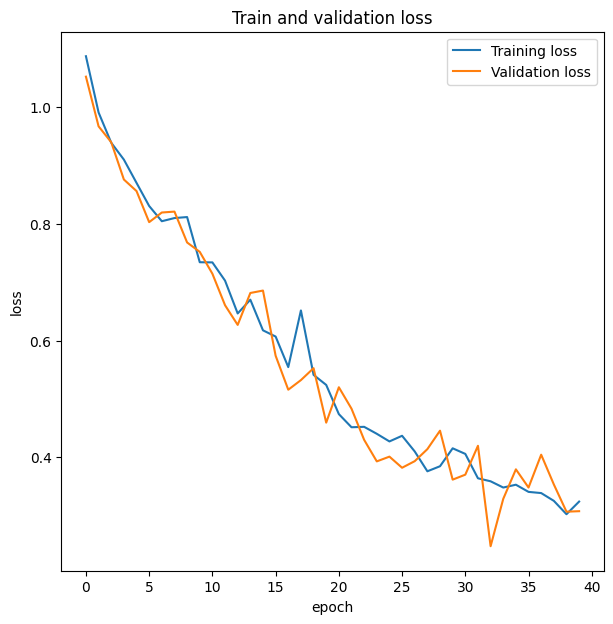

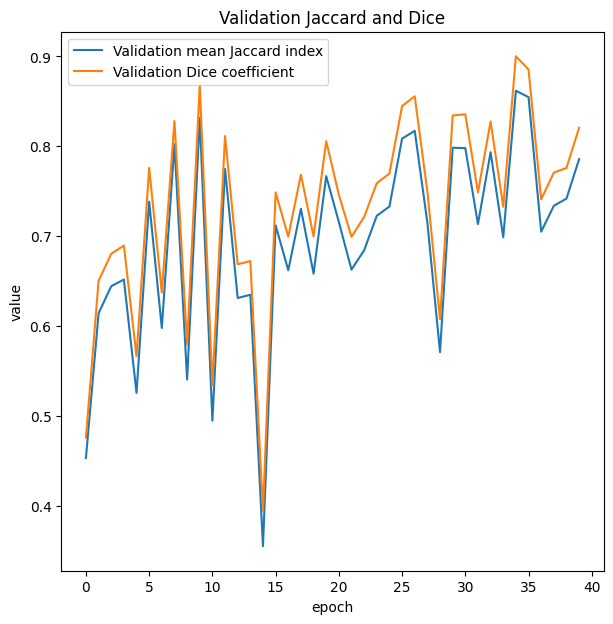

In [ ]:
if VISUALIZE_PLOTS:

  with open('/content/drive/MyDrive/MRI_segmetnation_project/results/history_universal_baseline_3d_unet_chunk_9_middle_flair_only_fold_0_2025_01_07-10_12_09_PM.json') as data_file:
      history = json.load(data_file)

  visualize_train_val_loss(history)
  plot_quality_metrics(history)

# Ensemble

In [ ]:
def get_latest_file(files, fold=0):
  def extract_timestamp(file_name): # Extract the timestamp portion
    date_str = file_name.split(f'_fold_{fold}_')[1].split('.pt')[0] # Convert to datetime object return # Convert to datetime object
    return datetime.strptime(date_str, "%Y_%m_%d-%I_%M_%S_%p") # Sort files by parsed timestamp, in descending order
  latest_file = max(files, key=extract_timestamp)
  return latest_file

In [ ]:
def load_model(model_information, fold):
  #loading model 1

  # Path to the folder containing the .pt files
  folder_path = model_information['MODELS_PATH']

  # Pattern to match the beginning of the filenames
  pattern = f"{model_information['MODEL_NAME']}_fold_{fold}"

  # List all files in the folder
  all_files = os.listdir(folder_path)

  # Filter files that start with the pattern and end with '.pt' and choose the most recent one

  matching_file_names =  [f for f in all_files if f.startswith(pattern) and f.endswith('.pt')]

  latest_file_name = get_latest_file(matching_file_names, fold=fold)

  weights_path = os.path.join(folder_path, latest_file_name)

  if model_information['CHUNK_SIZE'] > 1:
    model = UNet3d_new(in_channels=model_information['IN_CLASSES'], n_classes=1, n_channels=model_information['N_CHANNELS'], chunk_size=model_information['CHUNK_SIZE'])
  else:
    model = UNet2d(in_channels=model_information['IN_CLASSES'], n_classes=1, n_channels=model_information['N_CHANNELS'], chunk_size=model_information['CHUNK_SIZE'])

  model.to(device)

  model.load_state_dict(torch.load(weights_path, weights_only=True))

  return model

In [ ]:
def cross_validtion_ensemble_evalutation(model_information_1, model_information_2, data_paths, n_splits = 5):

    RESULTS_PATH = '/content/drive/MyDrive/MRI_segmetnation_project/results'


    current_time= datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    results_dictionary_path = os.path.join(RESULTS_PATH, f"ensemble_results_{model_information_1['MODEL_NAME']}_{model_information_2['MODEL_NAME']}_{current_time}.csv")

    df_chunk_19, arr_chunk_19 = load_data(data_dir = DATA_PATHS['chunk_19'])

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = defaultdict(list)

    for fold, (train_ids, valid_ids) in enumerate(kfold.split(arr_chunk_19)):

        print(f"calculating metrics for fold {fold}")

        valid_arr = arr_chunk_19[valid_ids]

        valid_df = df_chunk_19[df_chunk_19['Patient'].isin(valid_arr)]

        transform = None

        valid_dataset = MriDatasetDetailed(valid_df, is_channel_included=[True, True, True]) #use the same dataloader for both models and make the modifications for every model later

        test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

        #loading model 1

        model_1 = load_model(model_information_1, fold)

        #loading model 2

        model_2 = load_model(model_information_2, fold)

        history = evaluate_ensemble_model(test_loader, device, model_1, model_2, alpha=1, single_mask = True, chunk_slice=True, chunk_size_1=model_information_1['CHUNK_SIZE'], chunk_size_2=model_information_2['CHUNK_SIZE'], is_channel_included_1=model_information_1['IS_CHANNEL_INCLUDED'], is_channel_included_2 = model_information_2['IS_CHANNEL_INCLUDED'])

        results['val_loss'].append(history['val_loss'][0]) #
        results['val_IoU_ours'].append(history['val_IoU_ours'][0])
        results['val_IoU'].append(history['val_IoU'][0])
        results['val_dice'].append(history['val_dice'][0])
        results['val_acc'].append(history['val_acc'][0])
        results['val_precision'].append(history['val_precision'][0])
        results['val_recall'].append(history['val_recall'][0])
        results['val_f1'].append(history['val_f1'][0])
        results['val_specificity'].append(history['val_specificity'][0])

    results = pd.DataFrame(results)

    results['val_loss_mean'] = np.mean(results['val_loss'])
    results['val_IoU_mean'] = np.mean(results['val_IoU'])
    results['val_IoU_ours_mean'] = np.mean(results['val_IoU_ours'])
    results['val_dice_mean'] = np.mean(results['val_dice'])
    results['val_acc_mean'] = np.mean(results['val_acc'])
    results['val_recall_mean'] = np.mean(results['val_recall'])
    results['val_precision_mean'] = np.mean(results['val_precision'])
    results['val_f1_mean'] = np.mean(results['val_f1'])
    results['val_specificity_mean'] = np.mean(results['val_specificity'])

    results['val_loss_std'] = np.std(results['val_loss'])
    results['val_IoU_std'] = np.std(results['val_IoU'])
    results['val_IoU_ours_std'] = np.std(results['val_IoU_ours'])
    results['val_dice_std'] = np.std(results['val_dice'])
    results['val_acc_std'] = np.std(results['val_acc'])

    results.to_csv(results_dictionary_path, index=False)

    return results

In [ ]:
def evaluate_ensemble_model(test_loader, device, model_1, model_2, alpha=1, single_mask = False, chunk_slice=False, chunk_size_1=1, chunk_size_2=1, is_channel_included_1 = [True, True, True], is_channel_included_2 = [True, True, True]):

  history = defaultdict(list)

  is_channel_included_1 = [i for i, is_included  in enumerate(is_channel_included_1) if is_included==True]

  is_channel_included_2 = [i for i, is_included  in enumerate(is_channel_included_2) if is_included==True]

  model.eval()
  with torch.no_grad():

      iou_record = MeanMetric()
      f1_record = MeanMetric()
      precision_record = MeanMetric()
      recall_record = MeanMetric()
      specificity_record = MeanMetric()
      loss_record_validation = MeanMetric()

      acc_record = BinaryAccuracy()


      running_IoU = 0
      running_dice = 0
      running_valid_loss = 0
      running_IoU_ours = 0

      for i, data in enumerate(test_loader):

          img, mask, hist_grade, age, num_planes = data

          if chunk_slice:
            slices_to_remove = img.shape[2] - chunk_size_1
            if slices_to_remove //2 > 0:
              img_1 = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
            if chunk_size_1==1:
              img_1 = img_1.squeeze(2)

            slices_to_remove = img.shape[2] - chunk_size_2
            if slices_to_remove //2 > 0:
              img_2 = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
            if chunk_size_2==1:
              img_2 = img_2.squeeze(2)

          img_1 = img_1[:, is_channel_included_1,...]

          img_2 = img_2[:, is_channel_included_2,...]


          img_1, img_2, mask = img_1.to(device), img_2.to(device), mask.to(device)

          predictions_2 = model_2(img_2)
          predictions_1 = model_1(img_1)

          predictions = 0.5*(predictions_1 + predictions_2)

          predictions = predictions.squeeze(1)


          # Calculate stats and IoU
          mask = mask.int()

          tp, fp, fn, tn = smp.metrics.get_stats(predictions.unsqueeze(0), mask.unsqueeze(0), mode='binary', threshold=0.5)
          # Macro IoU and class-wise IoU

          iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
          f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
          precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
          recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
          specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="macro")


          acc_record.update(predictions.cpu(), mask.cpu())
          iou_record.update(iou_macro.cpu(), weight=img.shape[0])
          f1_record.update(f1_score.cpu(), weight=img.shape[0])
          recall_record.update(recall.cpu(), weight=img.shape[0])
          specificity_record.update(specificity.cpu(), weight=img.shape[0])
          precision_record.update(precision.cpu(), weight=img.shape[0])

          running_dice += dice_pytorch(predictions, mask, single_mask=single_mask).item()
          running_IoU_ours += iou_pytorch(predictions, mask, single_mask=single_mask).item()

          loss = focal_dice(predictions, mask, alpha)

          loss_record_validation.update(loss.detach().cpu().item(), weight=img.shape[0])

      val_loss = loss_record_validation.compute()
      # val_loss = running_valid_loss / len(valid_loader.dataset) #OK
      val_dice = running_dice / len(test_loader.dataset) #OK
      val_IoU_ours = running_IoU_ours / len(test_loader.dataset) #OK


      val_IoU = iou_record.compute() #OK
      val_acc = acc_record.compute() #ok
      val_f1 = f1_record.compute() #OK
      val_recall = recall_record.compute() #OK
      val_specificity = specificity_record.compute() #OK
      val_precision = precision_record.compute() #OK


      history['val_loss'].append(val_loss.item())
      history['val_IoU'].append(val_IoU.item())
      history['val_IoU_ours'].append(val_IoU_ours)
      history['val_dice'].append(val_dice)
      history['val_acc'].append(val_acc.item())
      history['val_precision'].append(val_precision.item())
      history['val_recall'].append(val_recall.item())
      history['val_specificity'].append(val_specificity.item())
      history['val_f1'].append(val_f1.item())


  return history


# cross validation flair only universal dataset - stabilized!

In [ ]:
chunk_to_batch_map = {1: 32, 3: 32, 5: 32, 7: 16, 9: 16, 11: 16, 13: 16, 15: 8, 17: 8, 19: 8}

In [ ]:
model_information = {}
model_information['ALPHA'] = 1
model_information['LR'] = 0.0001 #reduced learning rate for stability
model_information['IN_CLASSES'] = 1
model_information['N_CHANNELS'] = 24
model_information['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_1_middle'
model_information['EPOCHS'] = 100
model_information['MODELS_PATH'] = '/content/drive/MyDrive/MRI_segmetnation_project/models'
model_information['CHUNK_SIZE'] = 1
model_information['SINGLE_MASK'] = True
model_information['IS_CHANNEL_INCLUDED'] = [False, True, False]
model_information['BATCH_SIZE'] = 32

In [ ]:
# for chunk_size in range (1, 20, 2):

#   print(f"training started for chunk size = {chunk_size}")
#   model_information['CHUNK_SIZE'] = chunk_size
#   if chunk_size == 1:
#     model_information['MODEL_NAME'] = f'universal_baseline_2d_unet_chunk_{chunk_size}_flair_only'
#   else:
#     model_information['MODEL_NAME'] = f'universal_baseline_3d_unet_chunk_{chunk_size}_middle_flair_only'

#   model_information['BATCH_SIZE'] = chunk_to_batch_map[chunk_size]

#   results = cross_validtion_training(model_information, df, arr, n_splits = 5, data_paths = DATA_PATHS)


# cross validation pre+flair+post universal dataset - stabilized!

In [ ]:
chunk_to_batch_map = {1: 32, 3: 32, 5: 32, 7: 16, 9: 16, 11: 16, 13: 16, 15: 8, 17: 8, 19: 8}

In [ ]:
model_information = {}
model_information['ALPHA'] = 1
model_information['LR'] = 0.0002 #reduced learning rate for stability
model_information['IN_CLASSES'] = 3
model_information['N_CHANNELS'] = 24
model_information['MODEL_NAME'] = 'universal_baseline_2d_unet_chunk_1_pre_flair_post'
model_information['EPOCHS'] = 100
model_information['MODELS_PATH'] = '/content/drive/MyDrive/MRI_segmetnation_project/models'
model_information['CHUNK_SIZE'] = 1
model_information['SINGLE_MASK'] = True
model_information['IS_CHANNEL_INCLUDED'] = [True, True, True]
model_information['BATCH_SIZE'] = 32


In [ ]:
# for chunk_size in range (1, 20, 2):

#   print(f"training started for chunk size = {chunk_size}")
#   model_information['CHUNK_SIZE'] = chunk_size
#   if chunk_size == 1:
#     model_information['MODEL_NAME'] = f'universal_baseline_2d_unet_chunk_{chunk_size}_pre_flair_post'
#   else:
#     model_information['MODEL_NAME'] = f'universal_baseline_3d_unet_chunk_{chunk_size}_middle_pre_flair_post'

#   model_information['BATCH_SIZE'] = chunk_to_batch_map[chunk_size]

#   results = cross_validtion_training(model_information, df, arr, n_splits = 5, data_paths = DATA_PATHS)


# Ensmeble of multiple models - cross validation, results on universal test

In [ ]:
def evaluate_ensemble_model_universal(test_loader, device, models, chunk_sizes, is_channel_included_list, alpha=1, single_mask = True, chunk_slice=True, universal_test_loader=None, ensemble_method = "average", threshold = 0.5):

  history = defaultdict(list)

  is_channel_included_indices = []

  for is_channel_included in is_channel_included_list:
    is_channel_included_indices.append([i for i, is_included  in enumerate(is_channel_included) if is_included==True])

  for model in models:
    model.eval()

  with torch.no_grad():

      iou_record = MeanMetric()
      f1_record = MeanMetric()
      precision_record = MeanMetric()
      recall_record = MeanMetric()
      specificity_record = MeanMetric()
      loss_record_validation = MeanMetric()

      acc_record = BinaryAccuracy()


      running_IoU = 0
      running_dice = 0
      running_valid_loss = 0
      running_IoU_ours = 0


      universal_iou_record = MeanMetric()
      universal_f1_record = MeanMetric()
      universal_precision_record = MeanMetric()
      universal_recall_record = MeanMetric()
      universal_specificity_record = MeanMetric()
      universal_loss_record_validation = MeanMetric()

      universal_acc_record = BinaryAccuracy()

      universal_running_IoU = 0
      universal_running_dice = 0
      universal_running_valid_loss = 0
      universal_running_IoU_ours = 0


      for i, data in enumerate(test_loader):

          predictions_list = [] #maybe ordered dictionary?

          img, mask, hist_grade, age, num_planes = data

          for k, model in enumerate(models):

            if chunk_slice:
              slices_to_remove = img.shape[2] - chunk_sizes[k]
              if slices_to_remove //2 > 0:
                img_k = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
              if chunk_sizes[k]==1:
                img_k = img_k.squeeze(2)

            img_k = img_k[:, is_channel_included_indices[k],...]

            img_k, mask = img_k.to(device), mask.to(device)

            predictions_list.append(model(img_k))

          if ensemble_method == "average":

            predictions = (1/len(models))*sum(predictions_list)

          elif ensemble_method == "voting":

            models_binary_predictions = [torch.where(predictions > threshold, 1, 0) for predictions in predictions_list]

            models_binary_predictions_sum = sum(models_binary_predictions)

            predictions = torch.where(models_binary_predictions_sum > (len(predictions_list) // 2), 1, 0)

            predictions = predictions.to(torch.float32)

            if (len(predictions_list) % 2) == 0 :

              tie_mask =  torch.where(models_binary_predictions_sum == (len(predictions_list) // 2), 1, 0)

              average_predictions = (1/len(models))*sum(predictions_list)

              predictions = predictions + tie_mask * average_predictions

          predictions = predictions.squeeze(1)

          # Calculate stats and IoU
          mask = mask.int()

          tp, fp, fn, tn = smp.metrics.get_stats(predictions.unsqueeze(0), mask.unsqueeze(0), mode='binary', threshold=threshold)
          # Macro IoU and class-wise IoU

          iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
          f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
          precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
          recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
          specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="macro")


          acc_record.update(predictions.cpu(), mask.cpu())
          iou_record.update(iou_macro.cpu(), weight=img.shape[0])
          f1_record.update(f1_score.cpu(), weight=img.shape[0])
          recall_record.update(recall.cpu(), weight=img.shape[0])
          specificity_record.update(specificity.cpu(), weight=img.shape[0])
          precision_record.update(precision.cpu(), weight=img.shape[0])

          running_dice += dice_pytorch(predictions, mask, single_mask=single_mask, threshold=threshold).item()
          running_IoU_ours += iou_pytorch(predictions, mask, single_mask=single_mask, threshold=threshold).item()

          loss = focal_dice(predictions, mask, alpha)

          loss_record_validation.update(loss.detach().cpu().item(), weight=img.shape[0])

      for i, data in enumerate(universal_test_loader):

            predictions_list = [] #maybe ordered dictionary?

            img, mask, hist_grade, age, num_planes = data

            for k, model in enumerate(models):

              if chunk_slice:
                slices_to_remove = img.shape[2] - chunk_sizes[k]
                if slices_to_remove //2 > 0:
                  img_k = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
                if chunk_sizes[k]==1:
                  img_k = img_k.squeeze(2)

              img_k = img_k[:, is_channel_included_indices[k],...]

              img_k, mask = img_k.to(device), mask.to(device)

              predictions_list.append(model(img_k))

            if ensemble_method == "average":

              predictions = (1/len(models))*sum(predictions_list)

            elif ensemble_method == "voting":


              predcitions_concat = torch.cat(predictions_list, dim=1)

              std = torch.std(predcitions_concat, dim=1)


              models_binary_predictions = [torch.where(predictions > threshold, 1, 0) for predictions in predictions_list]

              models_binary_predictions_sum = sum(models_binary_predictions)

              predictions = torch.where(models_binary_predictions_sum > (len(predictions_list) // 2), 1, 0)


              predictions = predictions.to(torch.float32)

              if (len(predictions_list) % 2) == 0 :

                  print("even model number")

                  tie_mask =  torch.where(models_binary_predictions_sum == (len(predictions_list) // 2), 1, 0)

                  average_predictions = (1/len(models))*sum(predictions_list)

                  predictions = predictions + tie_mask * average_predictions

            predictions = predictions.squeeze(1)


            # Calculate stats and IoU
            mask = mask.int()

            tp, fp, fn, tn = smp.metrics.get_stats(predictions.unsqueeze(0), mask.unsqueeze(0), mode='binary', threshold=threshold)
            # Macro IoU and class-wise IoU

            iou_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')
            # print(tp, fp, fn, tn)
            # print(iou_macro)
            # print(iou_pytorch(predictions, mask, single_mask=single_mask).item())
            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
            specificity = smp.metrics.specificity(tp, fp, fn, tn, reduction="macro")


            universal_acc_record.update(predictions.cpu(), mask.cpu())
            universal_iou_record.update(iou_macro.cpu(), weight=img.shape[0])
            universal_f1_record.update(f1_score.cpu(), weight=img.shape[0])
            universal_recall_record.update(recall.cpu(), weight=img.shape[0])
            universal_specificity_record.update(specificity.cpu(), weight=img.shape[0])
            universal_precision_record.update(precision.cpu(), weight=img.shape[0])

            universal_running_dice += dice_pytorch(predictions, mask, single_mask=single_mask, threshold=threshold).item()
            universal_running_IoU_ours += iou_pytorch(predictions, mask, single_mask=single_mask, threshold=threshold).item()

            loss = focal_dice(predictions, mask, alpha)

            universal_loss_record_validation.update(loss.detach().cpu().item(), weight=img.shape[0])

      val_loss = loss_record_validation.compute()
      # val_loss = running_valid_loss / len(valid_loader.dataset) #OK
      val_dice = running_dice / len(test_loader.dataset) #OK
      val_IoU_ours = running_IoU_ours / len(test_loader.dataset) #OK


      val_IoU = iou_record.compute() #OK
      val_acc = acc_record.compute() #ok
      val_f1 = f1_record.compute() #OK
      val_recall = recall_record.compute() #OK
      val_specificity = specificity_record.compute() #OK
      val_precision = precision_record.compute() #OK

      universal_test_loss = universal_loss_record_validation.compute()
      # val_loss = running_valid_loss / len(valid_loader.dataset) #OK
      universal_test_dice = universal_running_dice / len(universal_test_loader.dataset) #OK
      universal_test_IoU_ours = universal_running_IoU_ours / len(universal_test_loader.dataset) #OK


      universal_test_IoU = universal_iou_record.compute() #OK
      universal_test_acc = universal_acc_record.compute() #ok
      universal_test_f1 = universal_f1_record.compute() #OK
      universal_test_recall = universal_recall_record.compute() #OK
      universal_test_specificity = universal_specificity_record.compute() #OK
      universal_test_precision = universal_precision_record.compute() #OK



      history['val_loss'].append(val_loss.item())
      history['val_IoU'].append(val_IoU.item())
      history['val_IoU_ours'].append(val_IoU_ours)
      history['val_dice'].append(val_dice)
      history['val_acc'].append(val_acc.item())
      history['val_precision'].append(val_precision.item())
      history['val_recall'].append(val_recall.item())
      history['val_specificity'].append(val_specificity.item())
      history['val_f1'].append(val_f1.item())

      history['universal_test_loss'].append(universal_test_loss.item())
      history['universal_test_IoU'].append(universal_test_IoU.item())
      history['universal_test_IoU_ours'].append(universal_test_IoU_ours)
      history['universal_test_dice'].append(universal_test_dice)
      history['universal_test_acc'].append(universal_test_acc.item())
      history['universal_test_precision'].append(universal_test_precision.item())
      history['universal_test_recall'].append(universal_test_recall.item())
      history['universal_test_specificity'].append(universal_test_specificity.item())
      history['universal_test_f1'].append(universal_test_f1.item())


  return history


In [ ]:
def universal_test_cross_validtion_ensemble_evalutation(models_information_list, data_paths, n_splits = 5, ensemble_method="average",  visualize = False):

    current_time= datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

    csv_name = "ensemble_results"

    for model_information in models_information_list:
      csv_name += f"_{model_information['MODEL_NAME']}"

    csv_name = "ensemble_pre_flair_post_1_3_5_7_average.csv"

    # csv_name += f"_{ensemble_method}_{current_time}.csv"

    results_dictionary_path = os.path.join(RESULTS_PATH, csv_name)

    df_chunk_19, arr_chunk_19 = load_data(data_dir = DATA_PATHS['chunk_19'])

    train_val_arr_chunk_19, test_arr_chunk_19 = train_test_split(arr_chunk_19, test_size=0.15, random_state=42)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = defaultdict(list)

    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_val_arr_chunk_19)):

        print(f"calculating metrics for fold {fold}")

        valid_arr = train_val_arr_chunk_19[valid_ids]

        valid_df = df_chunk_19[df_chunk_19['Patient'].isin(valid_arr)]

        universal_test_df = df_chunk_19[df_chunk_19['Patient'].isin(test_arr_chunk_19)]

        transform = None

        valid_dataset = MriDatasetDetailed(valid_df, is_channel_included=[True, True, True]) #use the same dataloader for both models and make the modifications for every model later

        test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

        universal_test_dataset = MriDatasetDetailed(universal_test_df, is_channel_included=[True, True, True])

        universal_test_loader = DataLoader(universal_test_dataset, batch_size=1, shuffle=True)

        models = []
        chunk_sizes = []
        is_channel_included_list = []

        for model_information in models_information_list:
          models.append(load_model(model_information, fold))
          chunk_sizes.append(model_information['CHUNK_SIZE'])
          is_channel_included_list.append(model_information['IS_CHANNEL_INCLUDED'])

        if visualize:
          Visualize_ensemble_model_universal(test_loader, device, models, alpha=1, single_mask = True, chunk_slice=True, chunk_sizes=chunk_sizes, is_channel_included_list=is_channel_included_list, universal_test_loader=universal_test_loader, ensemble_method=ensemble_method)
          break

        history = evaluate_ensemble_model_universal(test_loader, device, models, alpha=1, single_mask = True, chunk_slice=True, chunk_sizes=chunk_sizes, is_channel_included_list=is_channel_included_list, universal_test_loader=universal_test_loader, ensemble_method=ensemble_method)

        results['val_loss'].append(history['val_loss'][0]) #
        results['val_IoU_ours'].append(history['val_IoU_ours'][0])
        results['val_IoU'].append(history['val_IoU'][0])
        results['val_dice'].append(history['val_dice'][0])
        results['val_acc'].append(history['val_acc'][0])
        results['val_precision'].append(history['val_precision'][0])
        results['val_recall'].append(history['val_recall'][0])
        results['val_f1'].append(history['val_f1'][0])
        results['val_specificity'].append(history['val_specificity'][0])


        results['universal_test_loss'].append(history['universal_test_loss'][0]) #
        results['universal_test_IoU_ours'].append(history['universal_test_IoU_ours'][0])
        results['universal_test_IoU'].append(history['universal_test_IoU'][0])
        results['universal_test_dice'].append(history['universal_test_dice'][0])
        results['universal_test_acc'].append(history['universal_test_acc'][0])
        results['universal_test_precision'].append(history['universal_test_precision'][0])
        results['universal_test_recall'].append(history['universal_test_recall'][0])
        results['universal_test_f1'].append(history['universal_test_f1'][0])
        results['universal_test_specificity'].append(history['universal_test_specificity'][0])

    results = pd.DataFrame(results)

    if not visualize:

      results['val_loss_mean'] = np.mean(results['val_loss'])
      results['val_IoU_mean'] = np.mean(results['val_IoU'])
      results['val_IoU_ours_mean'] = np.mean(results['val_IoU_ours'])
      results['val_dice_mean'] = np.mean(results['val_dice'])
      results['val_acc_mean'] = np.mean(results['val_acc'])
      results['val_recall_mean'] = np.mean(results['val_recall'])
      results['val_precision_mean'] = np.mean(results['val_precision'])
      results['val_f1_mean'] = np.mean(results['val_f1'])
      results['val_specificity_mean'] = np.mean(results['val_specificity'])

      results['val_loss_std'] = np.std(results['val_loss'])
      results['val_IoU_std'] = np.std(results['val_IoU'])
      results['val_IoU_ours_std'] = np.std(results['val_IoU_ours'])
      results['val_dice_std'] = np.std(results['val_dice'])
      results['val_acc_std'] = np.std(results['val_acc'])


      results['universal_test_loss_mean'] = np.mean(results['universal_test_loss'])
      results['universal_test_IoU_mean'] = np.mean(results['universal_test_IoU'])
      results['universal_test_IoU_ours_mean'] = np.mean(results['universal_test_IoU_ours'])
      results['universal_test_dice_mean'] = np.mean(results['universal_test_dice'])
      results['universal_test_acc_mean'] = np.mean(results['universal_test_acc'])
      results['universal_test_recall_mean'] = np.mean(results['universal_test_recall'])
      results['universal_test_precision_mean'] = np.mean(results['universal_test_precision'])
      results['universal_test_f1_mean'] = np.mean(results['universal_test_f1'])
      results['universal_test_specificity_mean'] = np.mean(results['universal_test_specificity'])

      results['universal_test_loss_std'] = np.std(results['universal_test_loss'])
      results['universal_test_IoU_std'] = np.std(results['universal_test_IoU'])
      results['universal_test_IoU_ours_std'] = np.std(results['universal_test_IoU_ours'])
      results['universal_test_dice_std'] = np.std(results['universal_test_dice'])
      results['universal_test_acc_std'] = np.std(results['universal_test_acc'])


      # print(results)

      results.to_csv(results_dictionary_path, index=False)

    return results

In [ ]:
model_information = {}
model_information['ALPHA'] = 1
model_information['LR'] = 0.001
model_information['IN_CLASSES'] = 3
model_information['N_CHANNELS'] = 24
model_information['MODEL_NAME'] = 'universal_baseline_2d_unet_chunk_1_pre_flair_post'
model_information['EPOCHS'] = 100
model_information['MODELS_PATH'] = '/content/drive/MyDrive/MRI_segmetnation_project/models'
model_information['CHUNK_SIZE'] = 1
model_information['SINGLE_MASK'] = True
model_information['IS_CHANNEL_INCLUDED'] = [True, True, True]
model_information['BATCH_SIZE'] = 32
model_information_1 = model_information.copy()

In [ ]:
model_information_2 = model_information.copy()

model_information_2['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_3_middle_pre_flair_post'
model_information_2['CHUNK_SIZE'] = 3

In [ ]:
model_information_3 = model_information.copy()

model_information_3['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_5_middle_pre_flair_post'
model_information_3['CHUNK_SIZE'] = 5

In [ ]:
model_information_4 = model_information.copy()

model_information_4['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_7_middle_pre_flair_post'
model_information_4['CHUNK_SIZE'] = 7

In [ ]:
model_information_5 = model_information.copy()

model_information_5['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_9_middle_pre_flair_post'
model_information_5['CHUNK_SIZE'] = 9

In [ ]:
# universal_test_cross_validtion_ensemble_evalutation(models_information_list=[model_information_1, model_information_2, model_information_3, model_information_4], data_paths=DATA_PATHS, n_splits = 5, ensemble_method="average")

In [ ]:
  # Path to the folder containing the .pt files
  folder_path = model_information['MODELS_PATH']

  # Pattern to match the beginning of the filenames
  pattern = f"{model_information['MODEL_NAME']}_fold_{0}"

  # List all files in the folder
  all_files = os.listdir(folder_path)

  # Filter files that start with the pattern and end with '.pt'

  matching_file_names =  [f for f in all_files if f.startswith(pattern) and f.endswith('.pt')]

  print(matching_file_names)

  latest_file_name = get_latest_file(matching_file_names)

  weights_path = os.path.join(folder_path, latest_file_name)

  print("Latest file:", weights_path)

['universal_baseline_2d_unet_chunk_1_pre_flair_post_fold_0_2025_01_08-08_34_45_PM.pt', 'universal_baseline_2d_unet_chunk_1_pre_flair_post_fold_0_2025_01_08-08_53_35_PM.pt', 'universal_baseline_2d_unet_chunk_1_pre_flair_post_fold_0_2025_01_08-08_57_32_PM.pt']
Latest file: /content/drive/MyDrive/MRI_segmetnation_project/models/universal_baseline_2d_unet_chunk_1_pre_flair_post_fold_0_2025_01_08-08_57_32_PM.pt


In [ ]:
weights_path

'/content/drive/MyDrive/MRI_segmetnation_project/models/universal_baseline_2d_unet_chunk_1_pre_flair_post_fold_0_2025_01_08-08_57_32_PM.pt'

#Visaulize predictions

In [ ]:
def Visualize_ensemble_model_universal(test_loader, device, models, chunk_sizes, is_channel_included_list, alpha=1, single_mask = True, chunk_slice=True, universal_test_loader=None, ensemble_method = "average", threshold = 0.5, rows=3, columns=4):

  %matplotlib inline

  n_examples = columns * rows

  fig, axs = plt.subplots(rows, columns, figsize=(2*columns , 2*rows), constrained_layout=True)

  red_patch = mpatches.Patch(color='red', label='The red data')
  fig.legend(loc='upper right',handles=[
      mpatches.Patch(color='red', label='Ground truth'),
      mpatches.Patch(color='green', label='Predicted abnormality')])

  is_channel_included_indices = []

  for is_channel_included in is_channel_included_list:
    is_channel_included_indices.append([i for i, is_included  in enumerate(is_channel_included) if is_included==True])

  for model in models:
    model.eval()

  with torch.no_grad():

      for i, data in enumerate(universal_test_loader):

            predictions_list = [] #maybe ordered dictionary?

            img, mask, hist_grade, age, num_planes = data

            for k, model in enumerate(models):

              if chunk_slice:
                slices_to_remove = img.shape[2] - chunk_sizes[k]
                if slices_to_remove //2 > 0:
                  img_k = img[:,:, slices_to_remove//2:-slices_to_remove//2, ...]
                if chunk_sizes[k]==1:
                  img_k = img_k.squeeze(2)

              img_k = img_k[:, is_channel_included_indices[k],...]

              img_k, mask = img_k.to(device), mask.to(device)

              predictions_list.append(model(img_k))

            if ensemble_method == "average":

              predictions = (1/len(models))*sum(predictions_list)

            elif ensemble_method == "voting":


              predcitions_concat = torch.cat(predictions_list, dim=1)

              std = torch.std(predcitions_concat, dim=1)

              models_binary_predictions = [torch.where(predictions > threshold, 1, 0) for predictions in predictions_list]

              models_binary_predictions_sum = sum(models_binary_predictions)

              predictions = torch.where(models_binary_predictions_sum > (len(predictions_list) // 2), 1, 0)


              predictions = predictions.to(torch.float32)

              if (len(predictions_list) % 2) == 0 :

                  print("even model number")

                  tie_mask =  torch.where(models_binary_predictions_sum == (len(predictions_list) // 2), 1, 0)

                  average_predictions = (1/len(models))*sum(predictions_list)

                  predictions = predictions + tie_mask * average_predictions

            predictions = predictions.squeeze(0,1).cpu()

            mask = mask.int().cpu().squeeze(0)

            binary_prediction = torch.where(predictions > threshold, 1, 0)

            prediction_edges = binary_prediction - binary_dilation(binary_prediction)

            ground_truth = mask - binary_dilation(mask)

            slice_num = img.shape[2]//2


            img[0, 2, slice_num, ground_truth.bool()] = 1 #pre (image read as BGR instead of RGB)
            img[0, 1, slice_num, prediction_edges.bool()] = 1 #flair


            axs[i//columns][i%columns].imshow(img[0, :, slice_num,].to('cpu').permute(1, 2, 0)[:,:, (2,1,0)]) #move channels to last dimension,  convert BGR -> RGB for imshow

            axs[i//columns][i%columns].axis('off')

            if n_examples == i + 1:
                break




In [ ]:
model_information = {}
model_information['ALPHA'] = 1
model_information['LR'] = 0.0001 #reduced learning rate for stability
model_information['IN_CLASSES'] = 1
model_information['N_CHANNELS'] = 24
model_information['MODEL_NAME'] = 'universal_baseline_2d_unet_chunk_1_flair_only'
model_information['EPOCHS'] = 100
model_information['MODELS_PATH'] = '/content/drive/MyDrive/MRI_segmetnation_project/models'
model_information['CHUNK_SIZE'] = 1
model_information['SINGLE_MASK'] = True
model_information['IS_CHANNEL_INCLUDED'] = [False, True, False]
model_information['BATCH_SIZE'] = 32

model_information_1 = model_information.copy()

In [ ]:
model_information_2 = model_information.copy()

model_information_2['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_3_middle_flair_only'
model_information_2['CHUNK_SIZE'] = 3

In [ ]:
model_information_3 = model_information.copy()

model_information_3['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_5_middle_flair_only'
model_information_3['CHUNK_SIZE'] = 5

In [ ]:
model_information_4 = model_information.copy()

model_information_4['MODEL_NAME'] = 'universal_baseline_3d_unet_chunk_7_middle_flair_only'
model_information_4['CHUNK_SIZE'] = 7

calculating metrics for fold 0


""


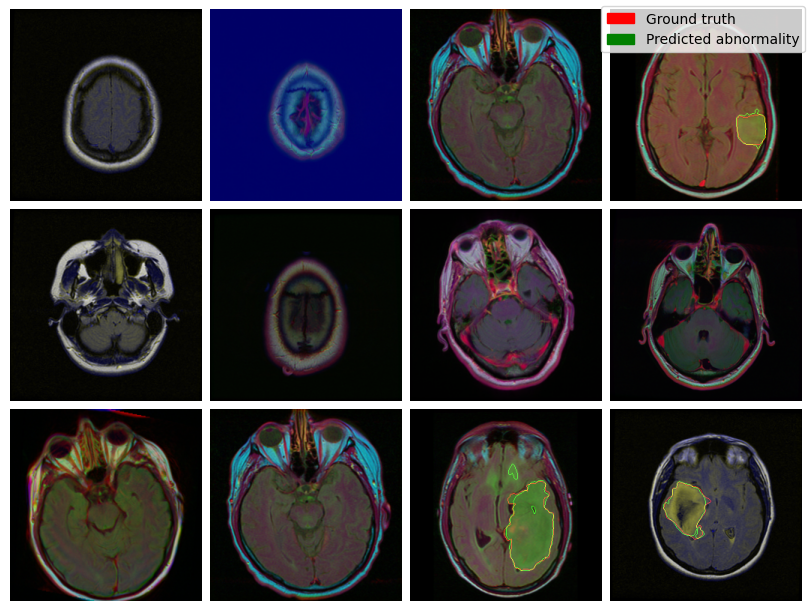

In [ ]:
universal_test_cross_validtion_ensemble_evalutation(models_information_list=[model_information_1, model_information_2, model_information_3, model_information_4], data_paths=DATA_PATHS, n_splits = 5, ensemble_method="average", visualize=True)